#Test FIRDeconvolution

###Imports

In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as pl
%matplotlib inline 

import seaborn as sn
sn.set(style="ticks")

from FIRDeconvolution import FIRDeconvolution

###Parameters specifying simulated data and analysis

In [2]:
# signal parameters
signal_sample_frequency = 5.0
event_1_gain, event_2_gain = 2.3, 0.85
noise_gain = 1.75

# deconvolution parameters
deconv_sample_frequency = 4.0
deconvolution_interval = [-5, 25]

# how many time points to plot in figures
plot_time = 800

# create some events of which we will create and deconvolve responses. 
period_durs = np.random.gamma(4.0,1.5,size = 600)
events = period_durs.cumsum()
events_1, events_2 = events[0::2], events[1::2]

# these events are scaled with their own underlying covariate. 
# for instance, you could have a model-based variable that scales the signal on a per-trial basis. 
events_gains_1 = np.random.randn(len(events_1))*0.4
events_gains_2 = np.random.randn(len(events_2))*2.4


###create an IRF which we'd like to deconvolve

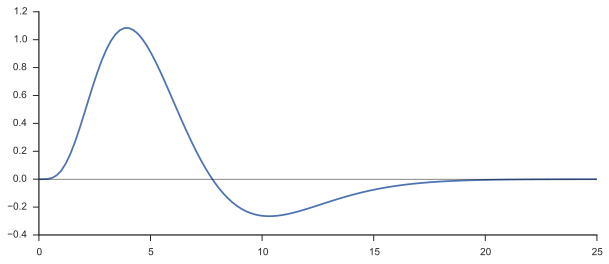

In [3]:
# We create an IRF, using a standard BOLD response.

def double_gamma_with_d(x, a1 = 6, a2 = 12, b1 = 0.9, b2 = 0.9, c = 0.35,d1=5.4,d2=10.8):
    return np.array([(t/(d1))**a1 * np.exp(-(t-d1)/b1) - c*(t/(d2))**a2 * np.exp(-(t-d2)/b2) for t in x])

hrf = double_gamma_with_d(np.linspace(0,25,25*signal_sample_frequency), a1 = 4.5, a2 = 10, d1 = 5.0, d2 = 10.0)
# hrf = hrf/np.abs(hrf).sum()

f = pl.figure(figsize = (10,4))
pl.plot(np.linspace(0,25,25*signal_sample_frequency), hrf)
pl.axhline(0, lw=0.5, color = 'k')
sn.despine()

#Run two simulations

1. deconvolve two types of events, each with different gains
2. deconvolve two types of events, of which the per-event gain is defined by a baseline, as in 1, and a covariate.

##Run first simulation

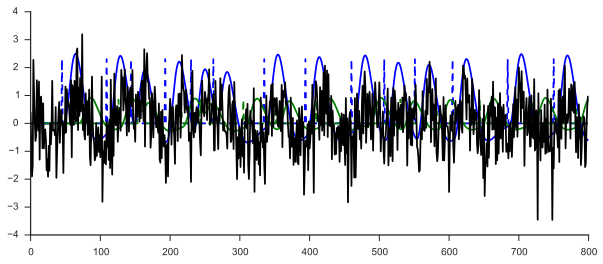

In [4]:
# Using this IRF we're going to create two signals
# signal gains are determined by random covariate and a standard gain
# we mix them all together with some noise, injected on the signal, not the events.

times = np.arange(0,events.max()+45.0,1.0/signal_sample_frequency)

event_1_in_times = np.array([((times>te) * (times<te+(1.0/signal_sample_frequency))) * event_1_gain for te in events_1]).sum(axis = 0)
event_2_in_times = np.array([((times>te) * (times<te+(1.0/signal_sample_frequency))) * event_2_gain for te in events_2]).sum(axis = 0)

signal_1 = sp.signal.fftconvolve(event_1_in_times, hrf, 'full')[:times.shape[0]]
signal_2 = sp.signal.fftconvolve(event_2_in_times, hrf, 'full')[:times.shape[0]]

# combine the two signals with one another, add noise and z-score
input_data = signal_1 + signal_2
input_data += np.random.randn(input_data.shape[0]) * noise_gain
input_data =  (input_data - np.mean(input_data)) / input_data.std()

f = pl.figure(figsize = (10,4))
pl.plot(np.arange(plot_time), event_1_in_times[:plot_time], 'b--')
pl.plot(np.arange(plot_time), event_2_in_times[:plot_time], 'g--')

pl.plot(np.arange(plot_time), signal_1[:plot_time], 'b-')
pl.plot(np.arange(plot_time), signal_2[:plot_time], 'g-')

pl.plot(np.arange(plot_time), input_data[:plot_time], 'k-')
sn.despine()

In [5]:
# Up until here, it was just creating data. 
# Now, we'll use the actual deconvolution package.

# first, we initialize the object
fd = FIRDeconvolution(
            signal = input_data, 
            events = [events_1, events_2], 
            event_names = ['event_1', 'event_2'], 
            sample_frequency = signal_sample_frequency,
            deconvolution_frequency = deconv_sample_frequency,
            deconvolution_interval = deconvolution_interval
            )
# we then tell it to create its design matrix
fd.create_design_matrix()

# perform the actual regression
fd.regress(method = 'sm_ols')

# and partition the resulting betas according to the different event types
fd.betas_for_events()

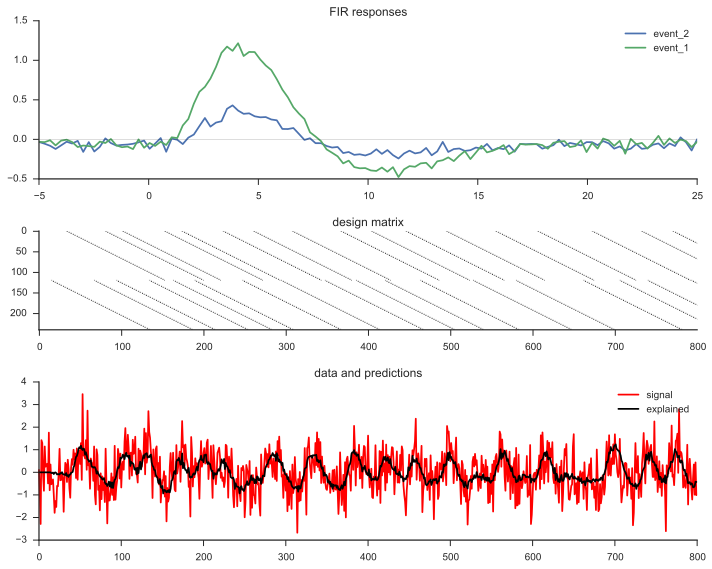

In [6]:
# and we see what we've done

f = pl.figure(figsize = (10,8))
s = f.add_subplot(311)
s.set_title('FIR responses')
for dec in fd.betas_per_event_type.squeeze():
    pl.plot(fd.deconvolution_interval_timepoints, dec)
# fd.covariates, being a dictionary, cannot be assumed to maintain the event order. 
# working on a fix here....
pl.legend(fd.covariates.keys())
sn.despine()

pl.axhline(0, lw=0.25, alpha=0.5, color = 'k')
s = f.add_subplot(312)
s.set_title('design matrix')
pl.imshow(fd.design_matrix[:,:plot_time], aspect = 0.075 * plot_time/fd.deconvolution_interval_size)
sn.despine()

s = f.add_subplot(313)
s.set_title('data and predictions')
pl.plot(fd.resampled_signal[:,:plot_time].T, 'r')
pl.plot(fd.predict_from_design_matrix(fd.design_matrix[:,:plot_time]).T, 'k')
pl.legend(['signal','explained'])
sn.despine()
pl.tight_layout()

##Run second simulation

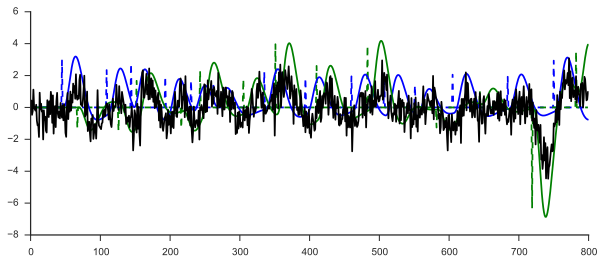

In [7]:
# Using this IRF we're going to create two signals
# signal gains are determined by random covariate per event and a standard gain
# we mix them all together with some noise, injected on the signal, not the events.

times = np.arange(0,events.max()+45.0,1.0/signal_sample_frequency)

event_1_in_times = np.array([((times>te) * (times<te+(1.0/signal_sample_frequency))) * (eg + event_1_gain) for te, eg in zip(events_1, events_gains_1)]).sum(axis = 0)
event_2_in_times = np.array([((times>te) * (times<te+(1.0/signal_sample_frequency))) * (eg + event_2_gain) for te, eg in zip(events_2, events_gains_2)]).sum(axis = 0)

signal_1 = sp.signal.fftconvolve(event_1_in_times, hrf, 'full')[:times.shape[0]]
signal_2 = sp.signal.fftconvolve(event_2_in_times, hrf, 'full')[:times.shape[0]]

# combine the two signals with one another, add noise and z-score
input_data = signal_1 + signal_2
input_data += np.random.randn(input_data.shape[0]) * noise_gain
input_data =  (input_data - np.mean(input_data)) / input_data.std()

f = pl.figure(figsize = (10,4))
pl.plot(np.arange(plot_time), event_1_in_times[:plot_time], 'b--')
pl.plot(np.arange(plot_time), event_2_in_times[:plot_time], 'g--')

pl.plot(np.arange(plot_time), signal_1[:plot_time], 'b-')
pl.plot(np.arange(plot_time), signal_2[:plot_time], 'g-')

pl.plot(np.arange(plot_time), input_data[:plot_time], 'k-')
sn.despine()

In [8]:
# But we haven't yet looked at the correlations
# the names of these are separated by a '.' to designate the events they belong to

covariates = {
    'event_1.gain': np.ones(len(events_1)), 
    'event_2.gain': np.ones(len(events_2)), 
    'event_1.corr': events_gains_1, 
    'event_2.corr': -events_gains_2, # note the multiplication with -1, for negative correlation
             }

# we initialize the object, now with the covariates
fd = FIRDeconvolution(
            signal = input_data, 
            events = [events_1, events_2], 
            event_names = ['event_1', 'event_2'], 
            sample_frequency = signal_sample_frequency,
            deconvolution_frequency = deconv_sample_frequency,
            deconvolution_interval = deconvolution_interval,
            covariates = covariates
            )
# we then tell it to create its design matrix
fd.create_design_matrix()

# perform the actual regression
fd.regress()

# and partition the resulting betas according to the different event types
fd.betas_for_events()

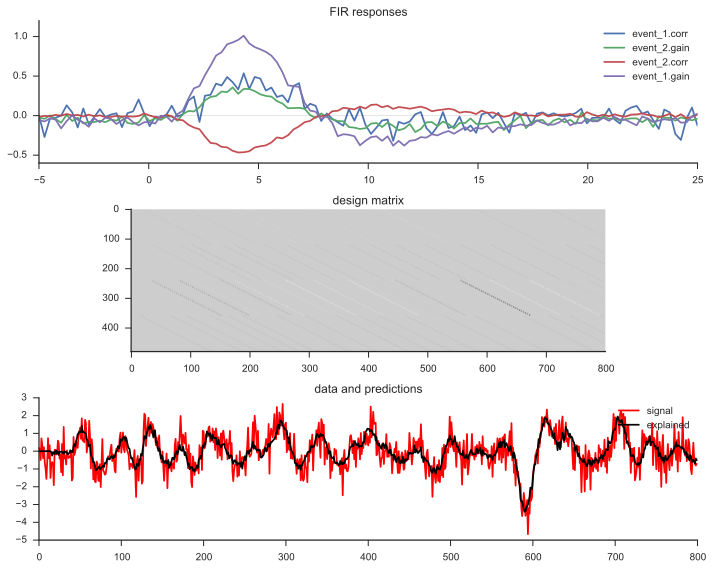

In [9]:
# and we see what we've done

f = pl.figure(figsize = (10,8))
s = f.add_subplot(311)
s.set_title('FIR responses')
for dec in fd.betas_per_event_type.squeeze():
    pl.plot(fd.deconvolution_interval_timepoints, dec)	
# pl.plot(fd.deconvolution_interval_timepoints, fd.betas_per_event_type.squeeze())	
pl.legend(fd.covariates.keys())
sn.despine()

pl.axhline(0, lw=0.25, alpha=0.5, color = 'k')
s = f.add_subplot(312)
s.set_title('design matrix')
pl.imshow(fd.design_matrix[:,:plot_time], aspect = 0.075 * plot_time/fd.deconvolution_interval_size)
sn.despine()

s = f.add_subplot(313)
s.set_title('data and predictions')
pl.plot(fd.resampled_signal[:,:plot_time].T, 'r')
pl.plot(fd.predict_from_design_matrix(fd.design_matrix[:,:plot_time]).T, 'k')
pl.legend(['signal','explained'])
sn.despine()
pl.tight_layout()